In [1]:
import pandas as pd
dt=pd.read_csv('donnees_vol_multiple.csv')
import numpy as np

In [2]:
df=dt
df=df.loc[df['erreur_m']<15]
df=df.drop(columns=['mission_id','real_y','real_z','real_x','battery_level'],axis=1)
df=df.drop(columns=['erreur_m'],axis=1)
variances = df.var()
Y=df['erreur_ok']
Y=Y.replace({
    'True':1 ,
    'False':0
})

In [3]:
df.shape

(4506, 22)

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['time']=scaler.fit_transform(df[['time']])
seuil = 150
mediane = df['erreur_cumulee_m'].median()

df.loc[df['erreur_cumulee_m'] > seuil, 'erreur_cumulee_m'] = mediane
X_ex=df
X_ex['ax']=np.exp(df['ax'])
X_ex['ay']=np.exp(df['ay'])
X_ex['ax']=np.exp(X_ex['ax'])
X_ex['ay']=np.exp(X_ex['ay'])


In [5]:
X_ex=X_ex.drop(columns=['erreur_ok'])

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ex, Y, test_size=0.2, random_state=42)

In [7]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

In [8]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Meilleurs paramètres LR :", grid_lr.best_params_)
print("Meilleur score LR :", grid_lr.best_score_)

c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

Meilleurs paramètres LR : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur score LR : 0.8806865464632455


c:\Users\NITRO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
from sklearn.metrics import accuracy_score, classification_report
best_lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000)
best_lr.fit(X_train, y_train)

y_pred = best_lr.predict(X_test)

print("Accuracy sur le jeu de test :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy sur le jeu de test : 0.876940133037694
              precision    recall  f1-score   support

       False       0.88      0.84      0.86       412
        True       0.87      0.91      0.89       490

    accuracy                           0.88       902
   macro avg       0.88      0.87      0.88       902
weighted avg       0.88      0.88      0.88       902



In [10]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
# Moyenne et écart-type
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

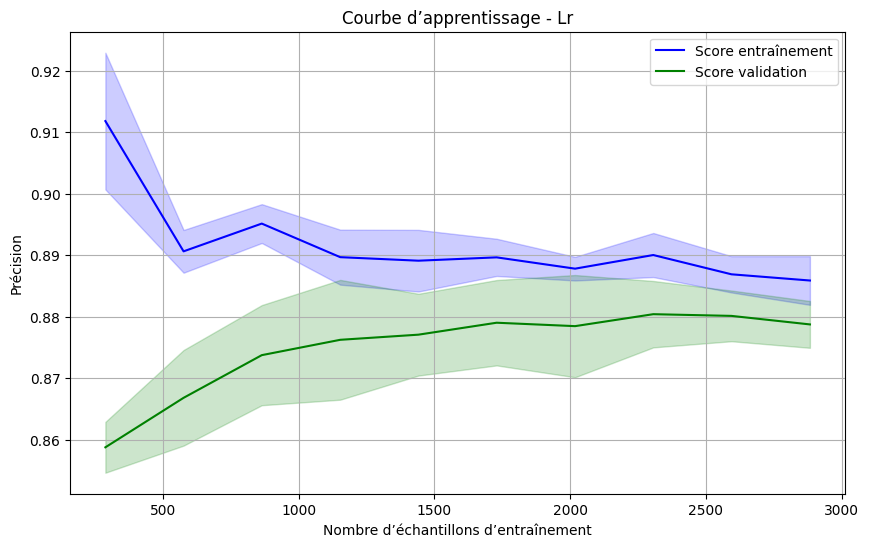

In [11]:
import matplotlib as plt
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Score entraînement', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean, label='Score validation', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Courbe d’apprentissage - Lr')
plt.xlabel('Nombre d’échantillons d’entraînement')
plt.ylabel('Précision')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
d_test=pd.read_csv('data_test_final.csv')
d_test=d_test.loc[d_test['erreur_m']<15]
d_test=d_test.drop(columns=['mission_id','real_y','real_z','real_x','battery_level'],axis=1)
d_test['time']=scaler.fit_transform(d_test[['time']])

Z=d_test
W=Z['erreur_ok']
Z=Z.drop(columns=['erreur_ok'])
Z=Z.drop(columns=['erreur_m'])
y_pred = best_lr.predict(Z)
W=W.replace({
    'True':1 ,
    'False':0
})
mediane = Z['erreur_cumulee_m'].median()

Z.loc[Z['erreur_cumulee_m'] > 150, 'erreur_cumulee_m'] = mediane
seuil = 3
Z['ax']=np.exp(Z['ax'])
Z['ay']=np.exp(Z['ay'])
Z['ax']=np.exp(Z['ax'])
Z['ay']=np.exp(Z['ay'])


mediane = Z['ax'].median()

Z.loc[Z['ax'] > seuil, 'ax'] = mediane
y_pred = best_lr.predict(Z)
print("Accuracy sur le jeu de test :", accuracy_score(W, y_pred))
print(classification_report(W, y_pred))

Accuracy sur le jeu de test : 0.8377659574468085
              precision    recall  f1-score   support

       False       0.87      0.81      0.84       394
        True       0.80      0.87      0.84       358

    accuracy                           0.84       752
   macro avg       0.84      0.84      0.84       752
weighted avg       0.84      0.84      0.84       752

